mfcc shape:  (49, 10)
stft: win stride = 320, fft size = 512, utilized input length = 15872


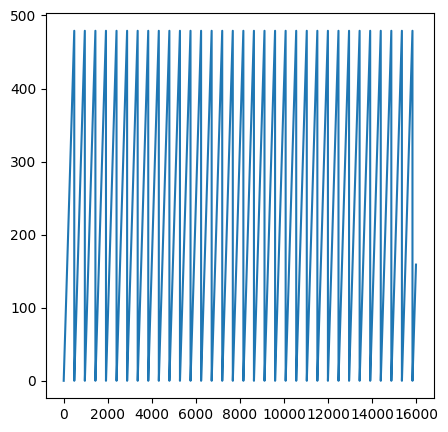

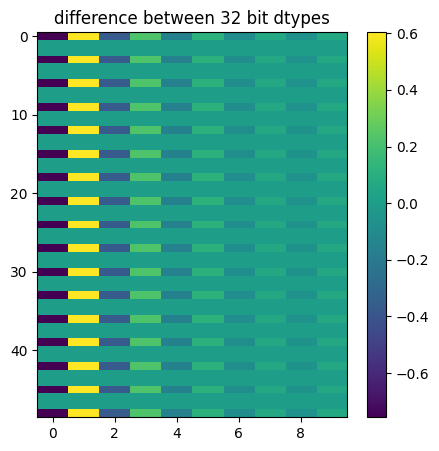

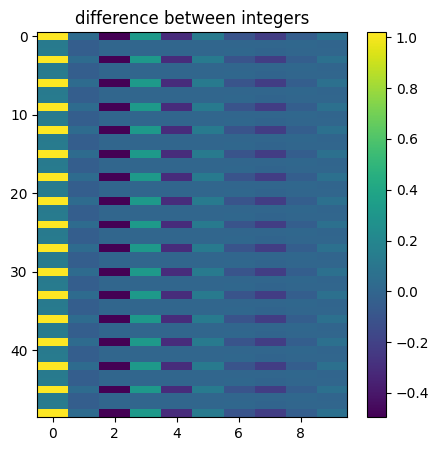

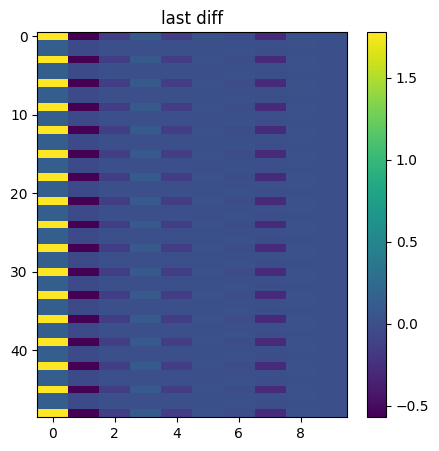

In [2]:
# %%

import cmsisdsp as dsp
import numpy as np
import cmsisdsp.fixedpoint as f
import cmsisdsp.datatype as dt
import cmsisdsp.mfcc as mfcc
import scipy.signal as sig

# from mfccdebugdata import *
from cmsisdsp.datatype import F32, Q31, Q15

import matplotlib.pyplot as plt

# parameters used in the tensorflow preprocessing (while training the model)
SAMPLE_RATE = 16000
WINDOW_SIZE_MS = 30.0
WINDOW_STRIDE_MS = 20.0
WINDOW_SIZE_SAMPLES = int(SAMPLE_RATE * WINDOW_SIZE_MS / 1000)
WINDOW_STRIDE_SAMPLES = int(SAMPLE_RATE * WINDOW_STRIDE_MS / 1000)
FFT_SIZE = int(2 ** np.ceil(np.log2([WINDOW_SIZE_SAMPLES]))[0])
NUM_OF_DCT_OUTPUTS = 10
FREQ_MIN = 20
FREQ_HIGH = 4000
NUM_OF_MEL_FILTERS = 40
WINDOW = sig.windows.hann(FFT_SIZE, sym=False)


def plot_mfcc(mfcc, title):
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(np.asarray(mfcc).squeeze(), aspect="auto", interpolation="nearest")
    fig.colorbar(im)
    ax.set_title(title)


# python code for the cmsis perprocessing code to be implemented on the microcontroller
#   one call to the mfcc function calculates the result for one window, so the functionality to result a spectrogram was added
def cmsis_mfcc(waveform, dtype="float32"):
    match dtype:
        case "float32":
            instance_fun = dsp.arm_mfcc_instance_f32
            init_fun = dsp.arm_mfcc_init_f32
            inference_fun = dsp.arm_mfcc_f32
            cmsis_dtype = F32
            deconvert_fun = lambda x: x
        case "int32":
            instance_fun = dsp.arm_mfcc_instance_q31
            init_fun = dsp.arm_mfcc_init_q31

            def inference_fun(*args):
                err, res = dsp.arm_mfcc_q31(*args)
                if err != 0:
                    print("Q31 inference error: ", err)
                return res

            cmsis_dtype = Q31
            deconvert_fun = lambda x: (1 << 8) * f.Q31toF32(x)
        case "int16":
            instance_fun = dsp.arm_mfcc_instance_q15
            init_fun = dsp.arm_mfcc_init_q15

            def inference_fun(*args):
                err, res = dsp.arm_mfcc_q15(*args)
                if err != 0:
                    print("Q15 inference error: ", err)
                return res

            cmsis_dtype = Q15
            deconvert_fun = lambda x: (1 << 8) * f.Q15toF32(x)
        case _:
            raise ValueError

    wave = np.asarray(waveform, dtype="float32")
    max = wave.max()
    if max != 0.0:
        wave = wave / max
    wave = dt.convert(wave, cmsis_dtype)

    window = dt.convert(WINDOW, cmsis_dtype)
    filtLen, filtPos, packedFilters = mfcc.melFilterMatrix(
        cmsis_dtype, FREQ_MIN, FREQ_HIGH, NUM_OF_MEL_FILTERS, SAMPLE_RATE, FFT_SIZE
    )
    dctMatrixFilters = mfcc.dctMatrix(
        cmsis_dtype, NUM_OF_DCT_OUTPUTS, NUM_OF_MEL_FILTERS
    )
    mfccf32 = instance_fun()
    status = init_fun(
        mfccf32,
        FFT_SIZE,
        NUM_OF_MEL_FILTERS,
        NUM_OF_DCT_OUTPUTS,
        dctMatrixFilters,
        filtPos,
        filtLen,
        packedFilters,
        window,
    )
    # print("MFCC init status: ", status)

    wave_len = len(np.squeeze(wave))
    steps = 1 + (wave_len - FFT_SIZE) // WINDOW_STRIDE_SAMPLES
    tmp = np.zeros(2 * FFT_SIZE, dtype=dtype)
    res = np.ndarray((steps, NUM_OF_DCT_OUTPUTS))
    for i in range(steps):
        # dst = (init, src, tmp_buffer)
        res[i, :] = inference_fun(
            mfccf32, wave[0:, i * WINDOW_STRIDE_SAMPLES :], tmp
        )
    res = deconvert_fun(res)
    return res


# fft size is 512
input = np.arange(16000).reshape(1, 16000)
input = input % WINDOW_SIZE_SAMPLES
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(input.squeeze())
res = cmsis_mfcc(input, dtype="int32")
res_f32 = cmsis_mfcc(input, dtype="float32")
res_i16 = cmsis_mfcc(input, dtype="int16")
print("mfcc shape: ", res.shape)

wave_len = 16000
utilized_input_len = (
    (wave_len - FFT_SIZE) // WINDOW_STRIDE_SAMPLES
) * WINDOW_STRIDE_SAMPLES + FFT_SIZE
print(
    f"stft: win stride = {WINDOW_STRIDE_SAMPLES}, fft size = {FFT_SIZE}, utilized input length = {utilized_input_len}"
)

plot_mfcc(res - res_f32, "difference between 32 bit dtypes")
plot_mfcc(res - res_i16, "difference between integers")
plot_mfcc(res_f32 - res_i16, "last diff")

In [3]:
# %%
# exporting the generated data to be used in the C implementation
cmsis_dtype_to_str = {F32: 'float32', Q31: 'q31', Q15: 'q15'}
for cmsis_dtype in [F32, Q31, Q15]:
    window = dt.convert(WINDOW, cmsis_dtype)
    filtLen, filtPos, packedFilters = mfcc.melFilterMatrix(
        cmsis_dtype, FREQ_MIN, FREQ_HIGH, NUM_OF_MEL_FILTERS, SAMPLE_RATE, FFT_SIZE
    )
    dctMatrixFilters = mfcc.dctMatrix(cmsis_dtype, NUM_OF_DCT_OUTPUTS, NUM_OF_MEL_FILTERS)
    def np_arr_to_header(arr: np.array):
        threshold = 32748
        assert(arr.size <= threshold)
        repr = np.array2string(arr, separator=", ", threshold=threshold)
        # strip []
        repr = repr.replace('[', ' ')
        repr = repr.replace(']', '')
        return repr

    for name_prefix, data in [
        ("window_mfcc_", window),
        ("filt_len_", filtLen),
        ("filt_pos_", filtPos),
        ("filter_coefs_", packedFilters),
        ("dct_coefs_", dctMatrixFilters),
    ]:
        with open(name_prefix + cmsis_dtype_to_str[cmsis_dtype] + ".h", "w") as file:
            repr = np_arr_to_header(np.asarray(data))
            file.write(repr)

(1, 16000) int16 [[-15 -18 -12 -21 -22 -13 -21 -22 -13  -3]]
float32
float64
[[ 0.72524261  0.0124104   0.10534596]
 [ 0.45496178 -0.2521348   0.05310774]
 [ 0.24255753  0.20928133 -0.1653893 ]]
Statistics of the ground truth: mean - -1.4340, abs mean - 3.0396, std - 7.1604, min - -31.9338, max - 19.1163
Statistics of the difference:   mean - 0.0171, abs mean - 0.1120, std - 0.1791, min - -0.5721, max - 1.3960


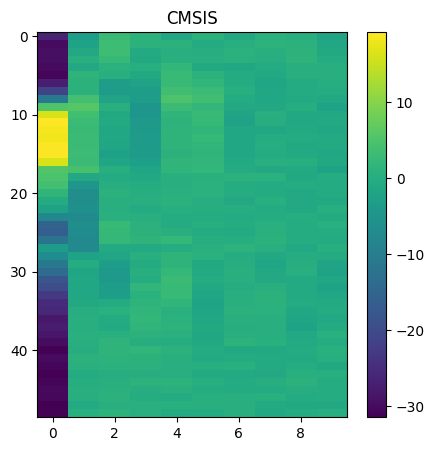

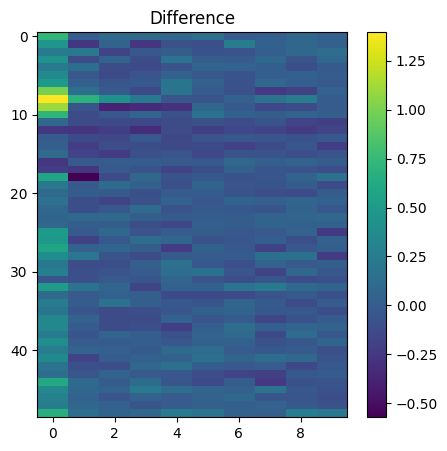

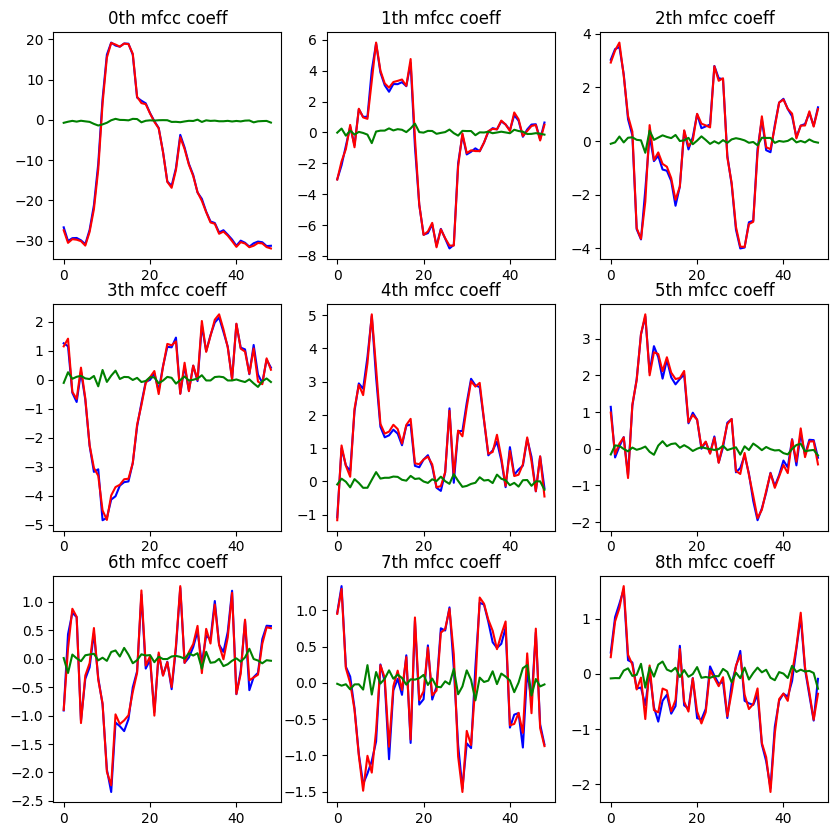

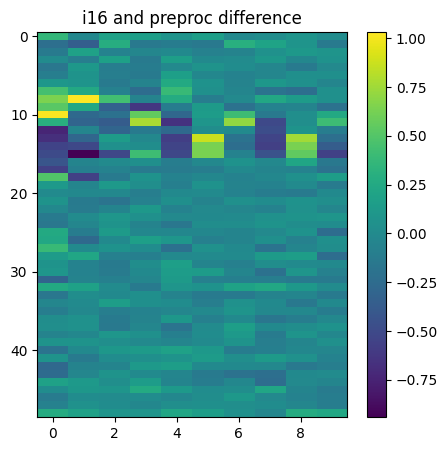

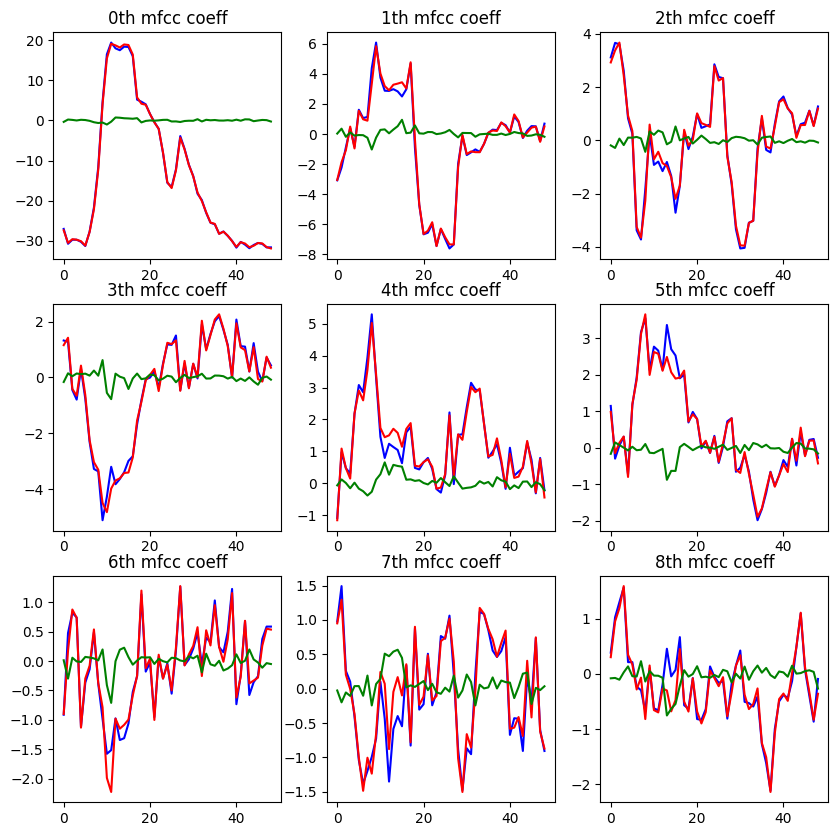

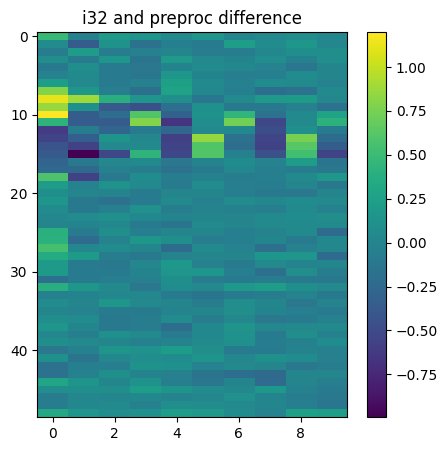

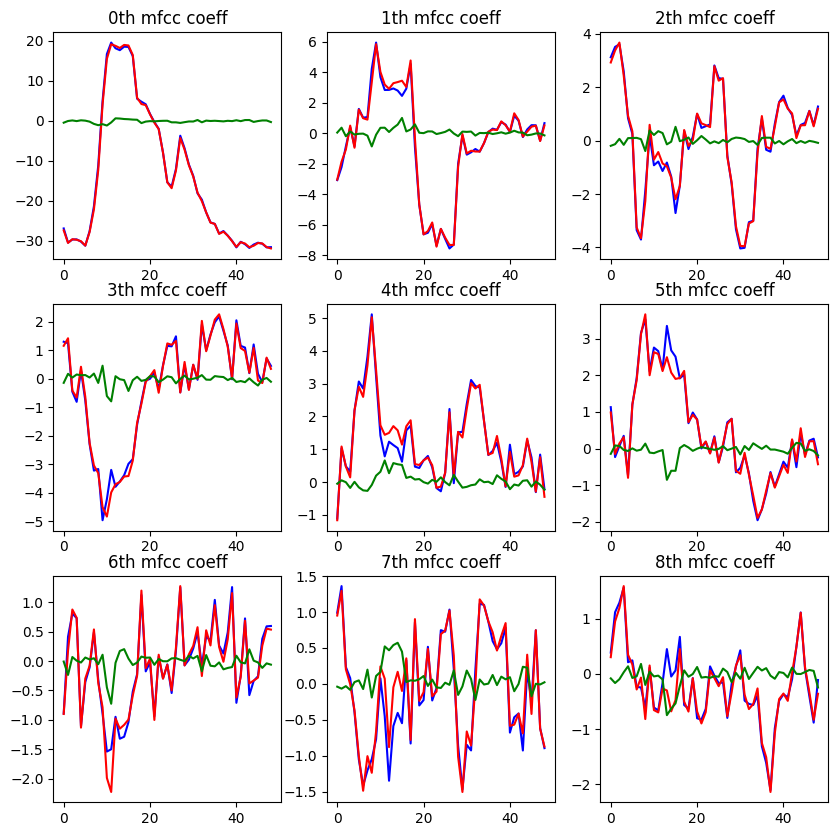

In [4]:
# %%
def get_flags():
    # default command line parameters from keyword_spotting.kws_util
    flags = Namespace(
        data_dir="/home/gergo/data",
        bg_path="/home/gergo/workspace",
        background_volume=0.1,
        background_frequency=0.8,
        silence_percentage=10.0,
        unknown_percentage=10.0,
        time_shift_ms=100.0,
        sample_rate=16000,
        clip_duration_ms=1000,
        window_size_ms=30.0,
        window_stride_ms=20.0,
        feature_type="mfcc",
        dct_coefficient_count=10,
        epochs=36,
        num_train_samples=-1,
        num_val_samples=-1,
        num_test_samples=-1,
        batch_size=100,
        num_bin_files=1000,
        bin_file_path="/home/gergo/kws_test_files",
        model_architecture="ds_cnn",
        run_test_set=True,
        saved_model_path="trained_models/kws_model.h5",
        model_init_path=None,
        tfl_file_name="trained_models/kws_model.tflite",
        learning_rate=1e-05,
        lr_sched_name="step_function",
        plot_dir="./plots",
        target_set="test",
    )
    return flags


# to be able to import the keyword_spotting code
import os, sys

# | hideline
__file__ = "/home/gergo/workspace/preprocessing/cmsis_dsp_exploration.ipynb"

curpath = os.path.dirname(__file__)
sys.path.append(os.path.join(curpath, os.path.pardir, "keyword_spotting"))

from argparse import Namespace
import tensorflow as tf
import get_dataset as gd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import keras_model as models

flags = get_flags()
flags.data_dir = "../dataset"
flags.batch_size = 1

# getting the preprocessed inputs
(ds_wave), _ = tfds.load(
    "speech_commands", split=["train"], data_dir=flags.data_dir, with_info=True
)
ds_wave = ds_wave[0]

# preprocessing with their function
label_count = 12
model_settings = models.prepare_model_settings(label_count, flags)
ds_preproc = ds_wave.map(
    gd.get_preprocess_audio_func(model_settings),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)
preproc_iter = iter(ds_preproc.take(1))
preproc_mfcc_matrix, preproc_label = next(preproc_iter).values()
preproc_mfcc_matrix = np.asarray(preproc_mfcc_matrix)

# getting the waverform and transforming using cmsis
wave_iter = iter(ds_wave.take(1))
wave, wave_label = next(wave_iter).values()
wave = np.asarray(wave).reshape(1, 16000)
print(wave.shape, wave.dtype, wave[:, :10])
calc_mfcc_matrix = cmsis_mfcc(wave)
calc_mfcc_matrix = calc_mfcc_matrix.reshape((1, 49, 10, 1))
calc_mfcc_matrix_i32 = cmsis_mfcc(wave, dtype="int32")
calc_mfcc_matrix_i32 = calc_mfcc_matrix_i32.reshape((1, 49, 10, 1))
calc_mfcc_matrix_i16 = cmsis_mfcc(wave, dtype="int16")
calc_mfcc_matrix_i16 = calc_mfcc_matrix_i16.reshape((1, 49, 10, 1))

# intermediate exploration of the loaded data
print(preproc_mfcc_matrix.dtype)
print(calc_mfcc_matrix.dtype)

plot_mfcc(calc_mfcc_matrix, "CMSIS")

diff_matrix = calc_mfcc_matrix.squeeze() - preproc_mfcc_matrix.squeeze()
plot_mfcc(diff_matrix, "Difference")
print(diff_matrix[:3, :3])
print(
    f"Statistics of the ground truth: mean - {preproc_mfcc_matrix.mean():.4f}, abs mean - {np.abs(preproc_mfcc_matrix).mean():.4f}, std - {preproc_mfcc_matrix.std():.4f}, min - {preproc_mfcc_matrix.min():.4f}, max - {preproc_mfcc_matrix.max():.4f}"
)
print(
    f"Statistics of the difference:   mean - {diff_matrix.mean():.4f}, abs mean - {np.abs(diff_matrix).mean():.4f}, std - {diff_matrix.std():.4f}, min - {diff_matrix.min():.4f}, max - {diff_matrix.max():.4f}"
)


# comparison for most of the mfcc coefficients, there is a small difference between the two methods, but not significant (the difference is noise-like)
def plot_mfcc_difference(calc_mfcc, preproc_mfcc):
    preproc_mfcc = np.asarray(preproc_mfcc).squeeze()
    calc_mfcc = np.asarray(calc_mfcc).squeeze()
    assert calc_mfcc.shape == preproc_mfcc.shape == (49, 10)
    diff = preproc_mfcc - calc_mfcc
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    for i in range(9):
        row = i // 3
        col = i % 3
        axs[row, col].plot(calc_mfcc[:, i], "b")
        axs[row, col].plot(preproc_mfcc[:, i], "r")
        axs[row, col].plot(diff[:, i], "g")
        axs[row, col].set_title(f"{i}th mfcc coeff")


plot_mfcc_difference(calc_mfcc_matrix, preproc_mfcc_matrix)

# there is a more significant difference between the mfccs with quantized calculation, if it is still acceptable depends on the test metrics
plot_mfcc(calc_mfcc_matrix_i16 - preproc_mfcc_matrix, "i16 and preproc difference")
plot_mfcc_difference(calc_mfcc_matrix_i16, preproc_mfcc_matrix)
plot_mfcc(calc_mfcc_matrix_i32 - preproc_mfcc_matrix, "i32 and preproc difference")
plot_mfcc_difference(calc_mfcc_matrix_i32, preproc_mfcc_matrix)

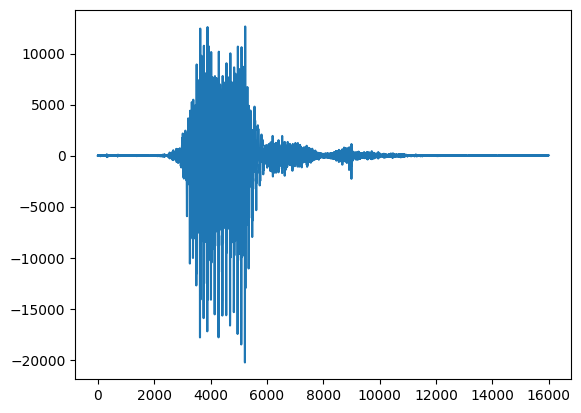

In [7]:
plt.plot(np.asarray(wave).squeeze())
with open('example_wave.h', 'w') as file:
    repr = np_arr_to_header(np.asarray(wave))
    file.write(repr)

DEBUG test wave2:  tf.Tensor([-15 -18 -12 ...  16  21  25], shape=(16000,), dtype=int16)


<StemContainer object of 3 artists>

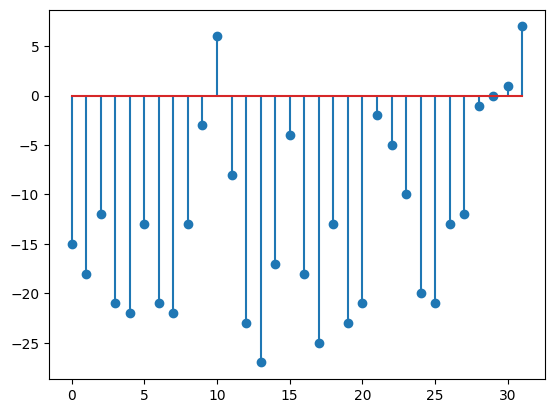

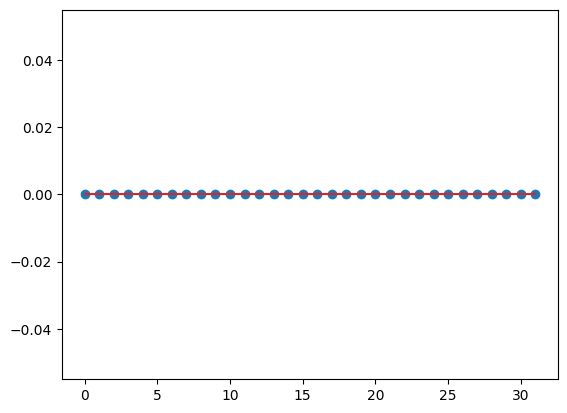

In [5]:
# %%
# checking that the pad part doesn't have any effect, so only the mfcc transformation happens after the max scaling
def padfunc(next_element):
    desired_samples = 16000
    wav_decoder = tf.cast(next_element["audio"], tf.float32)
    # Shift the sample's start position, and pad any gaps with zeros.
    time_shift_padding_placeholder_ = tf.constant([[2, 2]], tf.int32)
    time_shift_offset_placeholder_ = tf.constant([2], tf.int32)
    padded_foreground = tf.pad(
        wav_decoder, time_shift_padding_placeholder_, mode="CONSTANT"
    )
    sliced_foreground = tf.slice(
        padded_foreground, time_shift_offset_placeholder_, [desired_samples]
    )
    return sliced_foreground


ds_wave_test = ds_wave.map(padfunc)
test_wave = next(iter(ds_wave_test.take(1)))
plt.figure()
plt.stem(np.asarray(test_wave)[:32])
test_wave2, _ = next(iter(ds_wave.take(1))).values()
print("DEBUG test wave2: ", test_wave2)
plt.figure()
plt.stem(np.asarray(test_wave)[:32] - np.asarray(test_wave2)[:32])



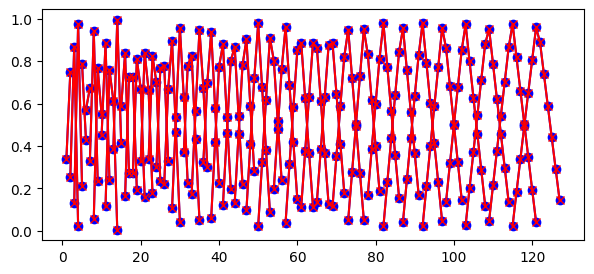

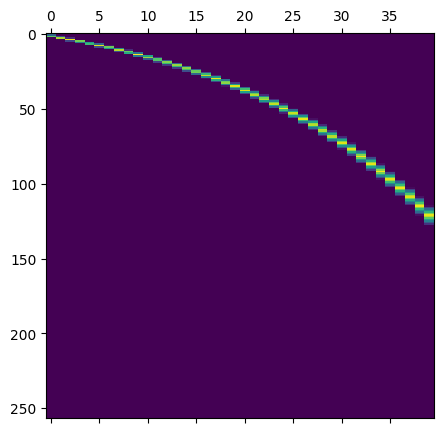

In [4]:
# %%
# checking if the mel conversion is the same in both libraries
filtLen, filtPos, packedFilters = mfcc.melFilterMatrix(
    F32, FREQ_MIN, FREQ_HIGH, NUM_OF_MEL_FILTERS, SAMPLE_RATE, FFT_SIZE
)

fig, ax = plt.subplots(figsize=(7, 3))
coeff_idx = 0
# plot cmsis filterbank
for pos, length in zip(filtPos, filtLen):
    x = np.arange(pos, pos + length)
    y = packedFilters[coeff_idx : coeff_idx + length]
    coeff_idx += length
    ax.plot(x, y, "bo-")

tf_mel_mat = np.asarray(
    tf.signal.linear_to_mel_weight_matrix(
        NUM_OF_MEL_FILTERS,
        FFT_SIZE // 2 + 1,
        SAMPLE_RATE,
        FREQ_MIN,
        FREQ_HIGH,
    )
)

# plot tf filterbank
for i in range(tf_mel_mat.shape[1]):
    col = tf_mel_mat[:, i]
    x = np.argwhere(col)
    y = col[x]
    ax.plot(x, y, "rx-")
# plt.plot(dctMatrixFilters)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(tf_mel_mat, aspect="auto", interpolation="nearest")


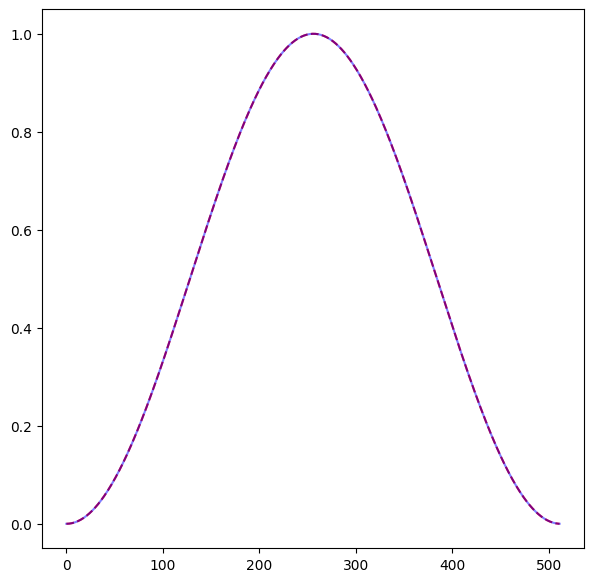

In [6]:
# %%
# checking the window functions
cmsis_dct_mat = mfcc.dctMatrix(F32, NUM_OF_DCT_OUTPUTS, NUM_OF_MEL_FILTERS)

tf_window = np.asarray(tf.signal.hann_window(FFT_SIZE))
cmsis_window = sig.windows.hann(FFT_SIZE, sym=False)

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(np.arange(len(tf_window)), tf_window, "r--")
ax.plot(np.arange(len(cmsis_window)), cmsis_window, "b", alpha=0.5)


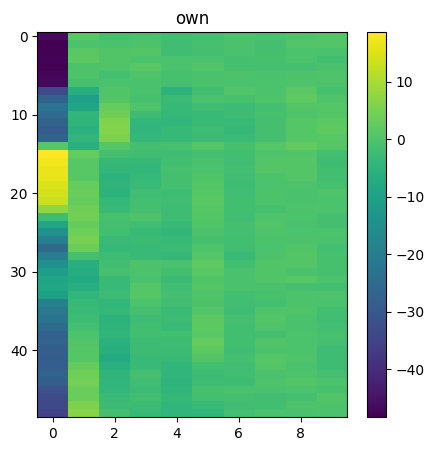

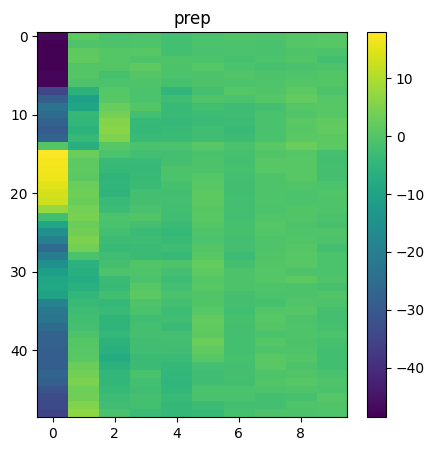

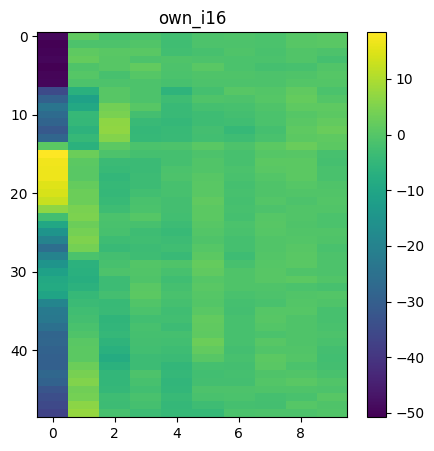

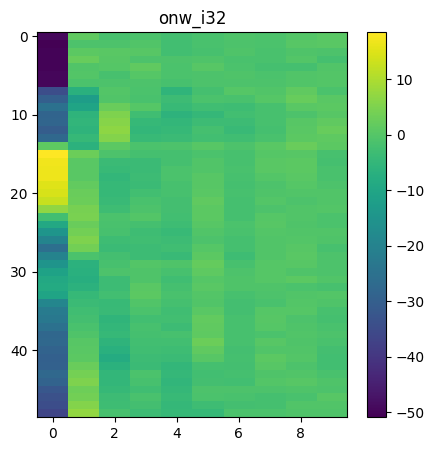

In [7]:
# %%

# not using val_cal_subset input flag, because it only restricts the validation dataset
# the preprocessed dataset using tensorflow
ds_train, ds_test, ds_val = gd.get_training_data(flags)

# getting the waverform and transforming using cmsis
ds_wave_train, ds_wave_test, ds_wave_val = gd.get_training_data(flags, get_waves=True)


def get_cmsis_map_function(dtype):
    def ds_wrapper(wave):
        return cmsis_mfcc(wave, dtype=dtype).reshape(1, 49, 10, 1)

    def map_fun(wave, label):
        return (tf.py_function(func=ds_wrapper, inp=[wave], Tout=np.float32), label)

    return map_fun


cmsis_float_fun = get_cmsis_map_function("float32")
cmsis_i32_fun = get_cmsis_map_function("int32")
cmsis_i16_fun = get_cmsis_map_function("int16")

# mapping for the float implementation
ds_cmsis_train = ds_wave_train.map(cmsis_float_fun)
ds_cmsis_test = ds_wave_test.map(cmsis_float_fun)
ds_cmsis_val = ds_wave_val.map(cmsis_float_fun)
# quantized version
ds_cmsis_i32_train = ds_wave_train.map(cmsis_i32_fun)
ds_cmsis_i32_test = ds_wave_test.map(cmsis_i32_fun)
ds_cmsis_i32_val = ds_wave_val.map(cmsis_i32_fun)
ds_cmsis_i16_train = ds_wave_train.map(cmsis_i16_fun)
ds_cmsis_i16_test = ds_wave_test.map(cmsis_i16_fun)
ds_cmsis_i16_val = ds_wave_val.map(cmsis_i16_fun)

for own, prep, own_i16, own_i32 in zip(
    ds_cmsis_test.take(1),
    ds_test.take(1),
    ds_cmsis_i16_test.take(1),
    ds_cmsis_i32_test.take(1),
):
    spect, label = own
    plot_mfcc(spect, "own")
    spect, label = prep
    plot_mfcc(spect, "prep")
    spect, label = own_i16
    plot_mfcc(spect, "own_i16")
    spect, label = own_i32
    plot_mfcc(spect, "onw_i32")


In [9]:
# %%


# source: relevant part of `keyword_spotting/make_bin_files.py`
def eval_dataset(dataset):
    output_type = np.int8
    interpreter = tf.lite.Interpreter(
        model_path="../keyword_spotting/trained_models/kws_ref_model.tflite"
    )
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_shape = input_details[0]["shape"]
    input_shape[0] = 0
    input_scale, input_zero_point = input_details[0]["quantization"]

    output_data = []
    labels = []

    eval_data = (
        dataset.unbatch().batch(1).as_numpy_iterator()
    )  # removed the take() call
    for dat, label in eval_data:
        # quantize input, the data is always float32
        dat_q = np.array(
            dat / input_scale + input_zero_point, dtype=output_type
        )  # should match input type in quantize.py

        interpreter.set_tensor(input_details[0]["index"], dat_q)
        interpreter.invoke()
        #  X.get_tensor() returns a copy of the tensor data; X.tensor() => pointer to the tensor
        output_data.append(
            np.argmax(interpreter.get_tensor(output_details[0]["index"]))
        )

        labels.append(label[0])

        num_correct = np.sum(np.array(labels) == output_data)
        acc = num_correct / len(labels)
    print(f"Accuracy = {acc:5.3f} ({num_correct}/{len(labels)})")


print("Evaluating on test sets (original, f32, i32, i16)")
eval_dataset(ds_test)
eval_dataset(ds_cmsis_test)
eval_dataset(ds_cmsis_i32_test)
eval_dataset(ds_cmsis_i16_test)

print("Evaluating on validation sets (original, f32, i32, i16)")
eval_dataset(ds_val)
eval_dataset(ds_cmsis_val)
eval_dataset(ds_cmsis_i32_val)
eval_dataset(ds_cmsis_i16_val)

print("Evaluating on train sets (original, f32, i32, i16)")
eval_dataset(ds_train)
num = 1000
eval_dataset(ds_cmsis_train.take(num))
eval_dataset(ds_cmsis_i32_train.take(num))
eval_dataset(ds_cmsis_i16_train.take(num))


Accuracy = 0.964 (964/1000)
Accuracy = 0.951 (951/1000)
Accuracy = 0.950 (950/1000)


Output:
```
Evaluating on test sets (original, f32, i32, i16)
Accuracy = 0.917 (4482/4890)
Accuracy = 0.918 (4490/4890)
Accuracy = 0.906 (4428/4890)
Accuracy = 0.911 (4453/4890)
Evaluating on validation sets (original, f32, i32, i16)
Accuracy = 0.956 (9655/10102)
Accuracy = 0.957 (9664/10102)
Accuracy = 0.945 (9550/10102)
Accuracy = 0.948 (9577/10102)
Evaluating on train sets (original, f32, i32, i16)
Accuracy = 0.968 (82778/85511)
Accuracy = 0.964 (964/1000) (these three only run on a small subset)
Accuracy = 0.951 (951/1000)
Accuracy = 0.950 (950/1000)
```

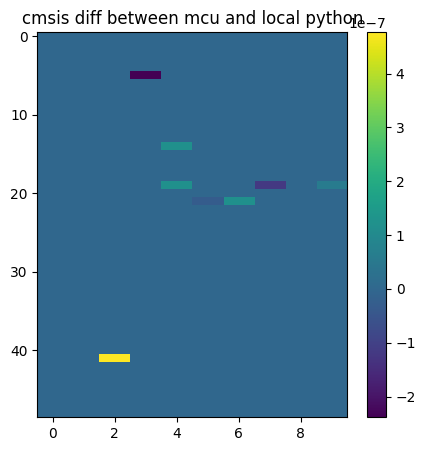

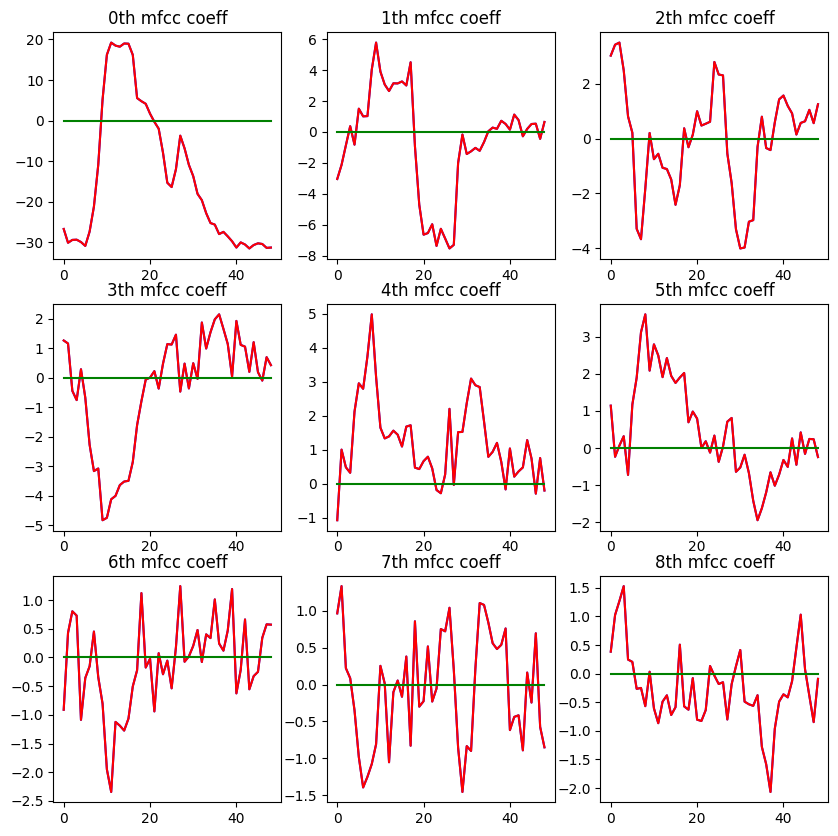

In [16]:
# %%
# comparison of the python and mcu implementation
import numpy as np
import ctypes

mfcc_dump = 'mfcc_hopeful.bin'

MFCC_SIZE = 490
mfcc_type = ctypes.c_float * MFCC_SIZE
with open(mfcc_dump, 'rb') as file:
    bin = file.read()
mfcc = mfcc_type.from_buffer_copy(bin)

import matplotlib.pyplot as plt

im = np.asarray(mfcc, dtype=ctypes.c_float)
im = im.reshape((1, 49, 10, 1))

plot_mfcc(im - calc_mfcc_matrix, "cmsis diff between mcu and local python")
plot_mfcc_difference(im, calc_mfcc_matrix)